In [37]:
# read_csv from all files in folder Zero2Heros/data/all year/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


# read csv file
#germ_data = pd.read_csv('/Users/anatolijkekarev/Desktop/jupyter_env/Zeros2Heros/data/all year/gen_DE_B01.csv', sep=',')

In [64]:
# list all the files the folder /Users/anatolijkekarev/Desktop/jupyter_env/Zeros2Heros/data/all year
path = '/Users/anatolijkekarev/Desktop/jupyter_env/Zeros2Heros/data/some year/'
files = os.listdir(path)
files

['load_SE.csv',
 'gen_DE_B19.csv',
 'gen_SE_B16.csv',
 'gen_SE_B13.csv',
 'gen_SE_B12.csv',
 'gen_SE_B19.csv']

In [72]:
limbo = pd.DataFrame()

def transform(x):
    # Your transformation logic here
    return pd.to_datetime(x)

def clean_data(name):
    # drop columns
    germ_data = pd.read_csv(f'/Users/anatolijkekarev/Desktop/jupyter_env/Zeros2Heros/data/all year/{name}', sep=',')
    print(f'applying the clean_data function to the file: {name}')
    if name.startswith('load'):
        #rename the column 'Load' to 'quantity'
        germ_data.rename(columns={'Load':'quantity'}, inplace=True)

    germ_data = germ_data[['quantity','StartTime']]
    germ_data = germ_data.drop(0)
    # Apply the split operation to the 'StartTime' column
    germ_data['StartTime'] = germ_data['StartTime'].apply(lambda s: s.split('+')[0])
    # Apply the transformation to the 'StartTime' column
    germ_data['StartTime'] = germ_data['StartTime'].apply(transform)
    #germ_data.index = germ_data['StartTime']
    #germ_data.drop('StartTime',axis=1,inplace=True)
    germ_data['quantity'] = germ_data['quantity'].astype(int)
    germ_data.resample('1H', on = 'StartTime').sum()
    new_name = name.replace('.csv', '').replace('load', 'loa')
    limbo[new_name] = germ_data['quantity']
    print('data appended to limbo')


In [73]:
for file in files:
    clean_data(name = file)

applying the clean_data function to the file: load_SE.csv
data appended to limbo
applying the clean_data function to the file: gen_DE_B19.csv
data appended to limbo
applying the clean_data function to the file: gen_SE_B16.csv
data appended to limbo
applying the clean_data function to the file: gen_SE_B13.csv
data appended to limbo
applying the clean_data function to the file: gen_SE_B12.csv
data appended to limbo
applying the clean_data function to the file: gen_SE_B19.csv
data appended to limbo


In [74]:
limbo.isna().sum()

loa_SE           0
gen_DE_B19       0
gen_SE_B16       1
gen_SE_B13    7729
gen_SE_B12       1
gen_SE_B19       1
dtype: int64

In [77]:
#drop gen_SE_B13
limbo.drop('gen_SE_B13', axis=1, inplace=True)
#check if nas are present in the same row 
limbo[limbo.isna().any(axis=1)]


KeyError: "['gen_SE_B13'] not found in axis"

In [85]:
limbo = limbo.drop(8759)
limbo.isna().sum()


KeyError: '[8759] not found in axis'

In [90]:
limbo.head()

,loa_SE,gen_DE_B19,gen_SE_B16,gen_SE_B12,gen_SE_B19,surplus_SE,prod_SE
1,15331,24604,0.0,7086.0,4021.0,35711.0,51042.0
2,15270,24177,0.0,7088.0,3948.0,35213.0,50483.0
3,15150,23491,0.0,6746.0,3763.0,34000.0,49150.0
4,15387,23528,0.0,7173.0,3597.0,34298.0,49685.0
5,15737,23138,0.0,7497.0,3355.0,33990.0,49727.0


<Axes: title={'center': 'Green energy loads and production in Sweden'}>

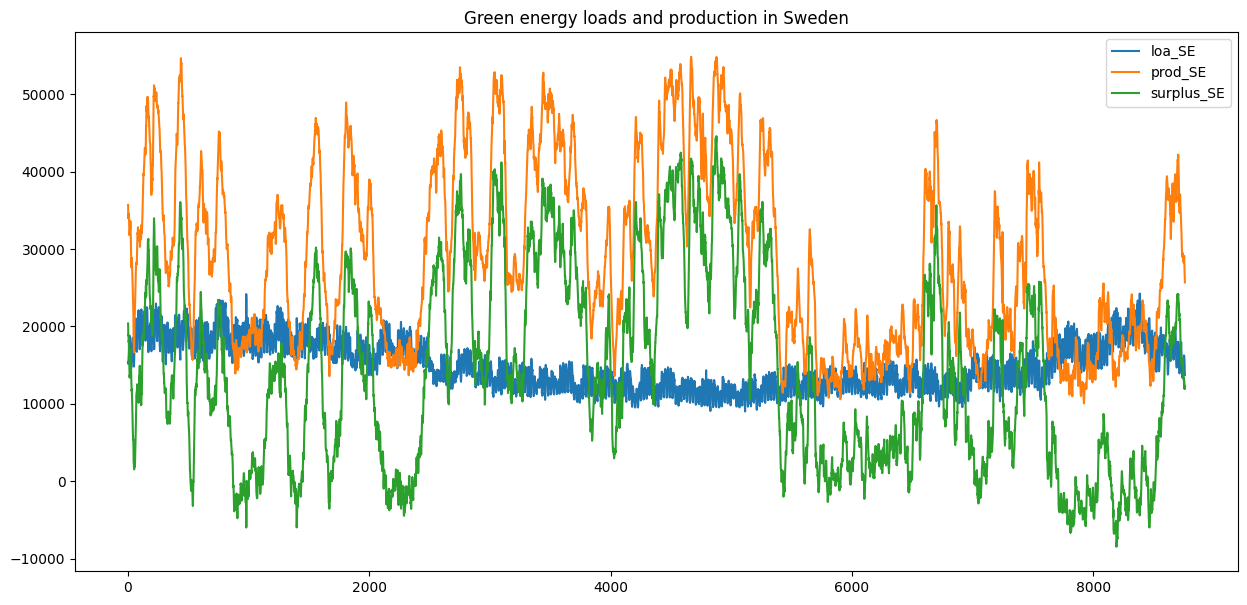

In [95]:
# sum all the columns that start with 'gen'
limbo['prod_SE'] = limbo.filter(regex='gen').sum(axis=1)

# calculate loa_SE minus all other variables sum
limbo['surplus_SE'] = limbo['prod_SE'] - limbo['loa_SE']
#plot all the data
limbo[['loa_SE', 'prod_SE', 'surplus_SE']].plot(subplots=False, figsize=(15,7), title='Green energy loads and production in Sweden') 

In [68]:
germ_data = germ_data[['quantity','StartTime']]

# Apply the split operation to the 'StartTime' column
germ_data['StartTime'] = germ_data['StartTime'].apply(lambda s: s.split('+')[0])

# Apply the split operation to the 'EndTime' column
germ_data['EndTime'] = germ_data['EndTime'].apply(lambda s: s.split('+')[0])

# Define your transformation function
def transform(x):
    # Your transformation logic here
    return pd.to_datetime(x)
# Apply the transformation to the 'StartTime' column
germ_data['StartTime'] = germ_data['StartTime'].apply(transform)
germ_data['EndTime'] = germ_data['EndTime'].apply(transform)
germ_data.drop(0,inplace=True)

germ_data.info()

AttributeError: 'Timestamp' object has no attribute 'split'

In [69]:
germ_data = pd.read_csv('/Users/anatolijkekarev/Desktop/jupyter_env/Zeros2Heros/data/all year/load_UK.csv', sep=',')
germ_data = germ_data.drop(0)

germ_data.rename(columns={'Load':'quantity'}, inplace=True)
germ_data = germ_data[['quantity','StartTime']]
germ_data['quantity'] = germ_data['quantity'].astype(int)
germ_data['StartTime'] = germ_data['StartTime'].apply(lambda s: s.split('+')[0])

germ_data['StartTime'] = germ_data['StartTime'].apply(transform)
germ_data.resample('1H', on = 'StartTime').sum()


,quantity
StartTime,
2022-01-01 00:00:00,1244
2022-01-01 01:00:00,1131
2022-01-01 02:00:00,1091
2022-01-01 03:00:00,969
2022-01-01 04:00:00,896
...,...
2022-07-17 19:00:00,786
2022-07-17 20:00:00,759
2022-07-17 21:00:00,1469


In [71]:
germ_data.isna().sum()

quantity     0
StartTime    0
dtype: int64